<a href="https://colab.research.google.com/github/xbadiam/Marketing_Campaign/blob/main/notebooks/MarketingCampaign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Campaña de marketing
Aumentar las ganancias de una campaña de marketing

### Contexto

Un modelo de respuesta puede aumentar significativamente la eficiencia de una campaña de marketing, ya sea incrementando las respuestas o reduciendo los gastos. El objetivo es predecir quién responderá a una oferta de un producto o servicio.

In [1]:
!rm -rf /content/Marketing_Campaign

! git clone https://github.com/xbadiam/Marketing_Campaign.git

Cloning into 'Marketing_Campaign'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 88 (delta 34), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (88/88), 2.38 MiB | 11.01 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import plotly.express as px

# Modelado
# ==============================================================================
from sklearn.pipeline import Pipeline
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA


## 3. Cargar datos

In [3]:
data = pd.read_csv('/content/Marketing_Campaign/outputs/output.csv')
data.head(10)

,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spending,Has_child,Living_With,Children
0,Graduate,Single,58138.0,Without_Kid,Without_Teen,2012-09-04,58,635,88,546,...,0,0,0,0,1,68,1617,0,Single,0
1,Graduate,Single,46344.0,With_Kid,With_Teen,2014-03-08,38,11,1,6,...,0,0,0,0,0,71,27,1,Single,2
2,Graduate,Together,71613.0,Without_Kid,Without_Teen,2013-08-21,26,426,49,127,...,0,0,0,0,0,60,776,0,Partner,0
3,Graduate,Together,26646.0,With_Kid,Without_Teen,2014-02-10,26,11,4,20,...,0,0,0,0,0,41,53,1,Partner,1
4,Postgraduate,Married,58293.0,With_Kid,Without_Teen,2014-01-19,94,173,43,118,...,0,0,0,0,0,44,422,1,Partner,1
5,Postgraduate,Together,62513.0,Without_Kid,With_Teen,2013-09-09,16,520,42,98,...,0,0,0,0,0,58,716,1,Partner,1
6,Graduate,Divorced,55635.0,Without_Kid,With_Teen,2012-11-13,34,235,65,164,...,0,0,0,0,0,54,590,1,Single,1
7,Postgraduate,Married,33454.0,With_Kid,Without_Teen,2013-05-08,32,76,10,56,...,0,0,0,0,0,40,169,1,Partner,1
8,Postgraduate,Together,30351.0,With_Kid,Without_Teen,2013-06-06,19,14,0,24,...,0,0,0,0,1,51,46,1,Partner,1
9,Postgraduate,Together,5648.0,With_Kid,With_Teen,2014-03-13,68,28,0,6,...,0,0,0,0,0,75,49,1,Partner,2


In [4]:
print("Número de características:", len(data.columns))
print("Longitud del conjunto de datos:", len(data))

Número de características: 30
Longitud del conjunto de datos: 2234


In [5]:
# Visualizamos los tipos de cada uno de los atributos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2234 entries, 0 to 2233
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2234 non-null   object 
 1   Marital_Status       2234 non-null   object 
 2   Income               2234 non-null   float64
 3   Kidhome              2234 non-null   object 
 4   Teenhome             2234 non-null   object 
 5   Dt_Customer          2234 non-null   object 
 6   Recency              2234 non-null   int64  
 7   MntWines             2234 non-null   int64  
 8   MntFruits            2234 non-null   int64  
 9   MntMeatProducts      2234 non-null   int64  
 10  MntFishProducts      2234 non-null   int64  
 11  MntSweetProducts     2234 non-null   int64  
 12  MntGoldProds         2234 non-null   int64  
 13  NumDealsPurchases    2234 non-null   int64  
 14  NumWebPurchases      2234 non-null   int64  
 15  NumCatalogPurchases  2234 non-null   i

## 4. Preprocesado

### 4.1. Reducción de dimensionalidad (PCA)

In [38]:
data_pca = data.copy()

#Selección de columnas
numeric_cols = data_pca.select_dtypes(include=['number']).columns.tolist()
cat_cols = data_pca.select_dtypes(include=['object', 'category']).columns.tolist()

In [39]:
# Preprocesamiento
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
])

In [56]:
# Pipeline PCA
pca_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('pca', PCA(n_components=0.95, svd_solver='full', random_state=42))
])

pca_model = pca_pipeline.fit_transform(data_pca)

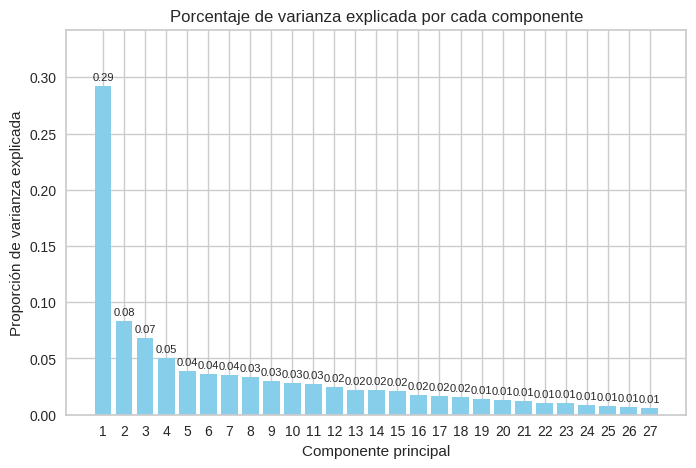

In [43]:
# Gráfico de los componentes
# ==============================================================================
# Obtenemos el objeto PCA del pipeline
pca_model = pca_pipeline.named_steps['pca']

# Gráfico de la varianza explicada
fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(
    x=np.arange(pca_model.n_components_) + 1,
    height=pca_model.explained_variance_ratio_,
    color='skyblue'
)

# Etiquetas de porcentaje sobre las barras
for i, v in enumerate(pca_model.explained_variance_ratio_):
    ax.text(i + 1, v + 0.005, f"{v:.2f}", ha='center', fontsize=8)

ax.set_xticks(np.arange(pca_model.n_components_) + 1)
ax.set_ylim(0, max(pca_model.explained_variance_ratio_) + 0.05)
ax.set_title('Porcentaje de varianza explicada por cada componente', fontsize=12)
ax.set_xlabel('Componente principal')
ax.set_ylabel('Proporción de varianza explicada')
plt.show()


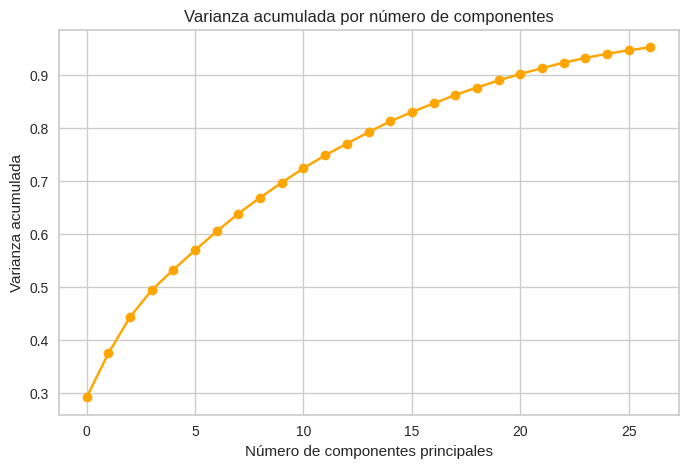

In [44]:
# Gráfico acumulativo
# ==============================================================================
plt.figure(figsize=(8, 5))
plt.plot(
    np.cumsum(pca_model.explained_variance_ratio_), marker='o', color='orange'
)
plt.title('Varianza acumulada por número de componentes')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza acumulada')
plt.grid(True)
plt.show()

In [60]:
# Get the PCA estimator from the pipeline
pca_estimator = pca_pipeline.named_steps['pca']

# Calcular la varianza explicada acumulada
varianza_acumulada = np.cumsum(pca_estimator.explained_variance_ratio_)

In [61]:
# Imprimir resultados
for i, var in enumerate(varianza_acumulada):
    print(f"Componentes: {i+1}, Varianza explicada acumulada: {var:.2f}")

Componentes: 1, Varianza explicada acumulada: 0.29
Componentes: 2, Varianza explicada acumulada: 0.38
Componentes: 3, Varianza explicada acumulada: 0.44
Componentes: 4, Varianza explicada acumulada: 0.49
Componentes: 5, Varianza explicada acumulada: 0.53
Componentes: 6, Varianza explicada acumulada: 0.57
Componentes: 7, Varianza explicada acumulada: 0.61
Componentes: 8, Varianza explicada acumulada: 0.64
Componentes: 9, Varianza explicada acumulada: 0.67
Componentes: 10, Varianza explicada acumulada: 0.70
Componentes: 11, Varianza explicada acumulada: 0.72
Componentes: 12, Varianza explicada acumulada: 0.75
Componentes: 13, Varianza explicada acumulada: 0.77
Componentes: 14, Varianza explicada acumulada: 0.79
Componentes: 15, Varianza explicada acumulada: 0.81
Componentes: 16, Varianza explicada acumulada: 0.83
Componentes: 17, Varianza explicada acumulada: 0.85
Componentes: 18, Varianza explicada acumulada: 0.86
Componentes: 19, Varianza explicada acumulada: 0.88
Componentes: 20, Vari

In [26]:
# Get the transformed data from the fitted pipeline
pca_transformed_data = pca_pipeline.transform(data_pca)

# Get the number of components from the PCA estimator object
# (pca_model here refers to the PCA estimator object from cell j8cxkmUe2McH)
num_components = pca_model.n_components_

# Create the DataFrame using the transformed data and correct number of components
PCA_dataset = pd.DataFrame(pca_transformed_data, columns=[f'PC{i+1}' for i in range(num_components)], index=data_pca.index)

In [ ]:
feature_importances